In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
from SimPEG.EM import Analytics

In [3]:
simDir = 'validate_VED_analytic'

# Validate against VED

Use geometry from the [well_A example](../casing3D/WellA.ipynb) to generate a mesh suitable for capturing casing parameters. Here, the well is a bit shorter to speed up calc and get away with a slightly shorter mesh 

## Example casing model

Here we ignore all conductivity and permeability structures and only use the geometry to generate the mesh

In [4]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1500 # use a well that is 1.5km long

freqs = np.r_[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.2, 0.5, 1.]  # 1e-6

sigma_back = 1e-1

src_a = np.r_[0., np.pi, -casing_l/2-0.5] # put the dipole in the center of the "well"
src_b = np.r_[0., np.pi, -casing_l/2+0.5]

## Whole space Model

In [5]:
# set up the casing properties
cp = casingSimulations.CasingParameters(
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_back,
    sigma_casing = sigma_back, 
    sigma_air = sigma_back,
    mur_casing = 1., 
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t,
    freqs = freqs, 
    src_a = src_a,
    src_b = src_b
)

In [6]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1500.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.5, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 1.0,
 'sigma_air': 0.1,
 'sigma_back': 0.1,
 'sigma_casing': 0.1,
 'sigma_inside': 0.1,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, -750.5],
 'src_b': [0.0, 3.141592653589793, -749.5],
 'version': u'0.0.1'}

In [7]:
cp.save(directory=simDir)

## Construct a mesh

In [8]:
npadx, npadz = 19, 24
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 5.
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

In [9]:
mesh = cylMeshGen.mesh

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


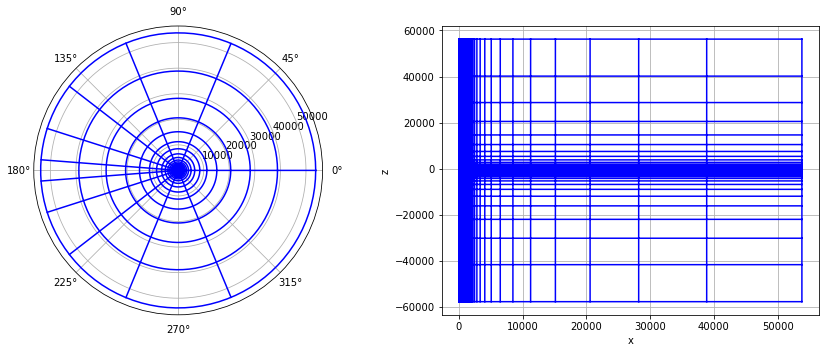

In [10]:
mesh.plotGrid()

In [11]:
print cp.skin_depth()

[ 159154.9430919    91888.14923697   50329.21210449   29057.58415663
   15915.49430919    9188.8149237     5032.92121045    3558.81271709
    2250.79079039    1591.54943092]


In [12]:
cylMeshGen.save(directory=simDir)

## Construct a source

In [13]:
src = casingSimulations.sources.VerticalElectricDipole(cp=cp, mesh=mesh)

(-760.0, -730.0)

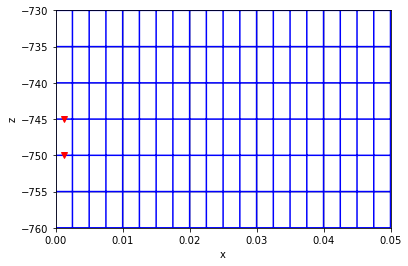

In [14]:
fig, ax = plt.subplots(1, 1)
mesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([0., 0.05])
ax.set_ylim([-760., -730.])

In [15]:
physprops = casingSimulations.PhysicalProperties(mesh, cp)

[(-2000.0, 0), (-2000.0, 0)]

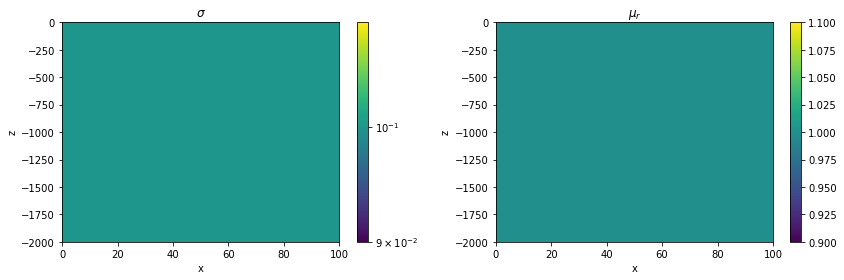

In [16]:
xlim = [0., 100.]
ylim = [-2000., 0]

ax = physprops.plot()
[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [17]:
set(physprops.sigma)

{0.10000000000000001}

In [18]:
set(physprops.mur)

{1.0}

In [19]:
casingSimulations.utils.writeSimulationPy(
    directory=simDir, 
    srcType='VerticalElectricDipole',
)

wrote validate_VED_analytic/simulation.py


# Load results

In [20]:
meshGen=casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
cp = casingSimulations.load_properties('/'.join([simDir, 'CasingParameters.json']))
hfield = np.load('/'.join([simDir, 'fields.npy']))

In [21]:
simulation = casingSimulations.run.SimulationFDEM(cp=cp, meshGenerator=meshGen, srcType='VerticalElectricDipole')
simulation.prob.model = simulation.physprops.model

In [22]:
fields = simulation.prob.fieldsPair(meshGen.mesh, simulation.survey)
fields[:,'hSolution'] = hfield

In [23]:
srcList = simulation.survey.srcList

In [29]:
mesh = meshGen.mesh
mesh2D = discretize.CylMesh([mesh.hx, 1., mesh.hz], x0=mesh.x0) # for plotting

In [30]:
# look at a slice along the plane of the source
srcind = 0
theta_ind = 1

jcyl = fields[srcList[srcind],'j']
jplt = casingSimulations.face3DthetaSlice(mesh, jcyl, theta_ind=theta_ind)
bcyl = fields[srcList[srcind], 'b']
bplt = casingSimulations.edge3DthetaSlice(mesh, bcyl, theta_ind=theta_ind)

print('freq: {} Hz'.format(srcList[srcind].freq))

freq: 0.0001 Hz


In [31]:
src_a = simulation.src.src_a
src_b = simulation.src.src_b
print(src_a, src_b)

(array([   0.        ,    3.14159265, -750.5       ]), array([   0.        ,    3.14159265, -749.5       ]))


In [32]:
# compare against analytic 

length = -mesh.hz.min()*2
loc = (src_a + src_b)/2.
current = 1.

eana_x, _, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridFx, loc, sig=cp.sigma_back, f=np.r_[cp.freqs[srcind]], current=current, 
    length=length, orientation='Z'
)
_, _, eana_z = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridFz, loc, sig=cp.sigma_back, f=np.r_[cp.freqs[srcind]], current=current, 
    length=length, orientation='Z'
)
eana = utils.mkvc(np.hstack([eana_x, eana_z]),2)
jana = cp.sigma_back * eana

eccx, _, eccz = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridCC, loc, sig=cp.sigma_back, f=np.r_[cp.freqs[srcind]], current=current, 
    length=length, orientation='Z'    
)

ecc_ana = utils.mkvc(np.hstack([eccx, eccz]),2)

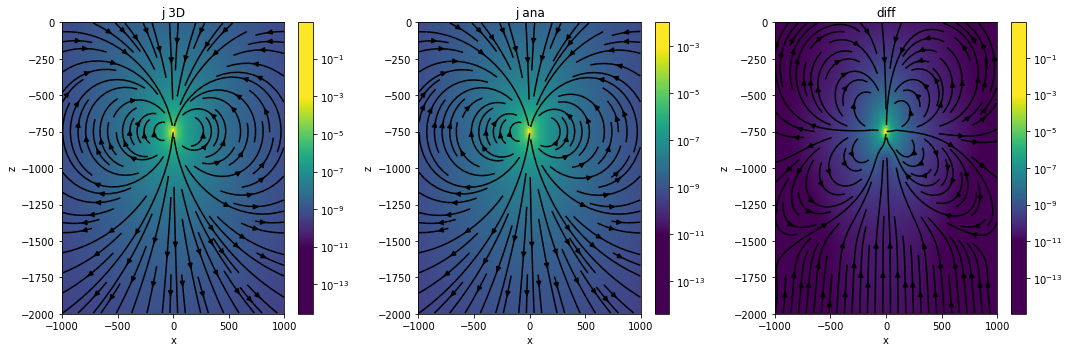

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'mirror':True,
    'range_x':np.r_[-1000., 1000.],
    'range_y':np.r_[-2000., 0.],
    'sample_grid':np.r_[10., 10.],
    'clim':np.r_[1e-11, 1e-3]
}


casingSimulations.plotFace2D(
    mesh2D, jplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jana, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jplt-jana, ax=ax[2], **pltargs
)

ax[0].set_title('j 3D')
ax[1].set_title('j ana')
ax[2].set_title('diff')


plt.tight_layout()

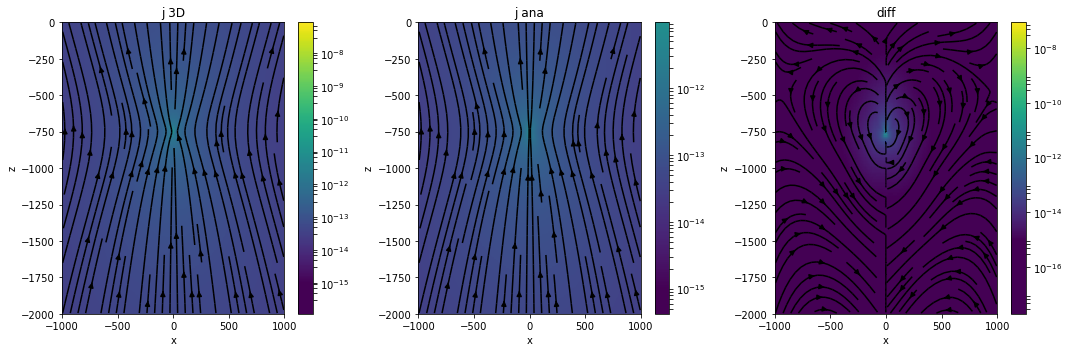

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pltargs = {
    'real_or_imag': 'imag',
    'mirror':True,
    'range_x':np.r_[-1000., 1000.],
    'range_y':np.r_[-2000., 0.],
    'sample_grid':np.r_[10., 10.],
    'clim':np.r_[1e-15, 1e-7]
}


casingSimulations.plotFace2D(
    mesh2D, jplt, ax=ax[0], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jana, ax=ax[1], **pltargs
)
casingSimulations.plotFace2D(
    mesh2D, jplt-jana, ax=ax[2], **pltargs
)

ax[0].set_title('j 3D')
ax[1].set_title('j ana')
ax[2].set_title('diff')


plt.tight_layout()

In [77]:
def plot_lines(x, e3D=None, eana=None, xlim=[0., 100.], name=None, xlabel=None):
    fig, ax = plt.subplots(3, 2, figsize=(12,8))
    ax = utils.mkvc(ax)
    
    plt_ind = (x > xlim[0]) & (x < xlim[1])
    
    x = x[plt_ind]
    if e3D is not None: e3D = e3D[plt_ind]
    if eana is not None: eana = eana[plt_ind]
    
    # Plot real
    if any(eana.real > 0): 
        if e3D is not None: ax[0].semilogy(x, e3D.real, '-g', label='3D')
        if eana is not None: ax[0].semilogy(x, eana.real, '-r', label='ana')
    if any(eana.real < 0): 
        if e3D is not None: ax[0].semilogy(x, -e3D.real, '--g', label='3D')
        if eana is not None: ax[0].semilogy(x, -eana.real, '--r', label='ana')
        
    ax[0].set_xlim(xlim)
    ax[0].set_title('{} real'.format(name))
    ax[0].legend()

    if e3D is not None: ax[1].semilogy(x, np.absolute(e3D.real - eana.real), '-g', label='3D')

    ax[1].set_xlim(xlim)
    ax[1].set_title('{} error real'.format(name))
    ax[1].legend()

    if e3D is not None: ax[2].plot(
        x, (e3D.real - eana.real)/(eana.real), '-g', label='3D'
    )

    ax[2].set_xlim(xlim)
    ax[2].set_title('{} error real'.format(name))
    ax[2].legend()

    if any(eana.imag > 0):
        if e3D is not None: ax[3].semilogy(x, e3D.imag, '-g', label='3D')
        ax[3].semilogy(x, eana.imag, '-r', label='ana')
    if any(eana.imag < 0): 
        if e3D is not None: ax[3].semilogy(x, -e3D.imag, '--g', label='3D')
        ax[3].semilogy(x, -eana.imag, '--r', label='ana')
        
    ax[3].set_title('{} imag'.format(name))
    ax[3].set_xlim(xlim)
    ax[3].legend()

    if e3D is not None: ax[4].semilogy(x, np.absolute(e3D.imag - eana.imag), '-g', label='3D')

    ax[4].set_xlim(xlim)
    ax[4].set_title('{} error imag'.format(name))
    ax[4].legend()

    if e3D is not None: ax[5].plot(
        x, (e3D.imag - eana.imag)/(eana.imag), '-g', label='3D'
    )

    ax[5].set_xlim(xlim)
    ax[5].set_title('{} error imag'.format(name))
    ax[5].legend()
    
    [a.set_ylim(0.1*np.r_[-1, 1]) for a in [ax[2], ax[5]]]
    [a.set_ylim([np.absolute(eana.real).min()*0.05, np.absolute(eana.real).max()*2]) for a in ax[:2]]
    [a.set_ylim([np.absolute(eana.imag).min()*0.05, np.absolute(eana.imag).max()*2]) for a in ax[3:4]]
    [a.grid(which='both', linestyle='-', color=[0.8, 0.8, 0.8, 0.5], linewidth=0.5) for a in ax]
    
    if xlabel is not None:
        [a.set_xlabel(xlabel) for a in ax]
    plt.tight_layout()
        
    return fig, ax

    

In [78]:
# line plots
src_ind = 0
theta_ind = 1

esrc = fields[srcList[srcind], 'e']
eplt = casingSimulations.face3DthetaSlice(mesh, esrc, theta_ind)

e3D_x = eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
e3D_z = eplt[-mesh2D.vnF[2]:].reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

eana_x = eana_x.reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F')
eana_z = eana_z.reshape([mesh2D.vnFz[0], mesh2D.vnFz[2]], order='F')

looking at z=2.5


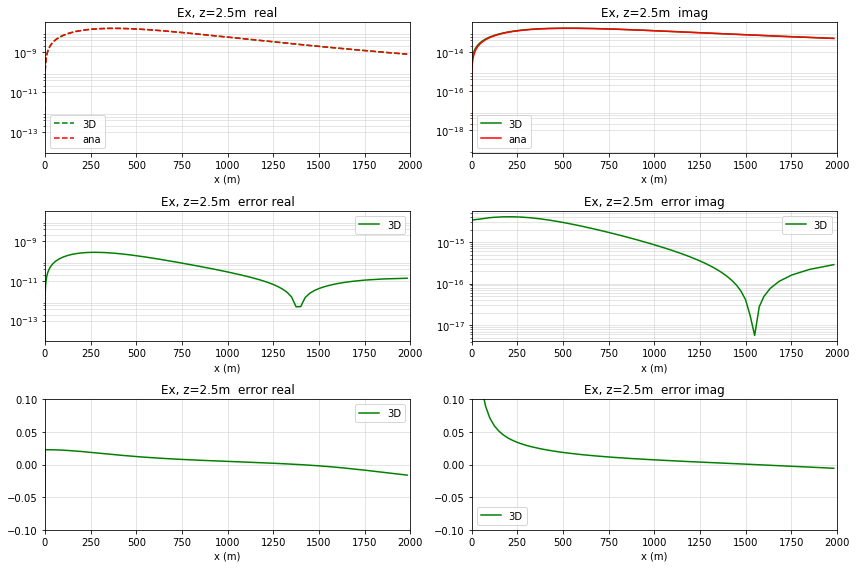

In [79]:
z_ind = mesh2D.vnC[2]/2 + 150
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(
    mesh2D.vectorNx,  e3D_x[:, z_ind], eana_x[:, z_ind], xlim=[0., 2000.], 
    name='Ex, z={}m '.format(mesh2D.vectorCCz[z_ind]), xlabel='x (m)'
)

looking at x=137.5


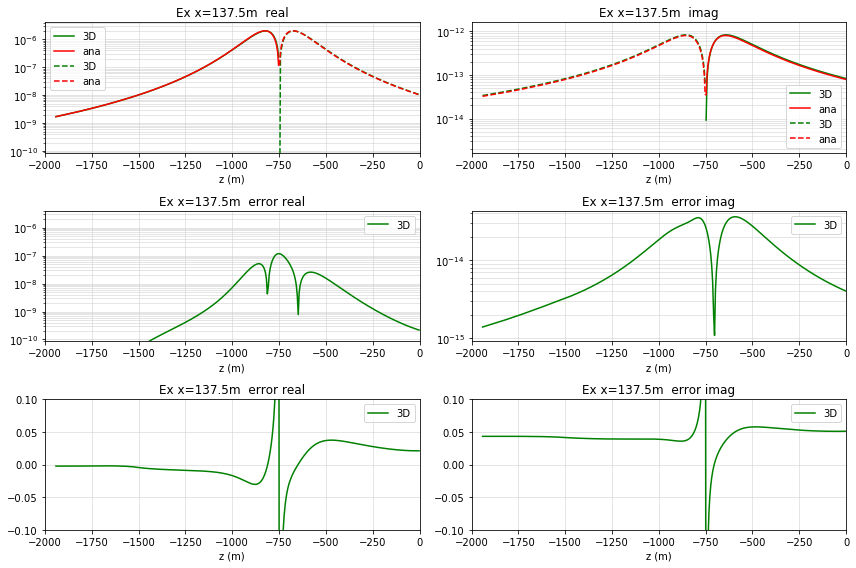

In [93]:
x_ind =  80
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(
    mesh2D.vectorCCz, e3D_x[x_ind, :], eana_x[x_ind, :], xlim=[-2000., 0.], 
    name='Ex x={}m '.format(mesh2D.vectorCCx[x_ind]), xlabel = 'z (m)'
)

looking at z=2.5


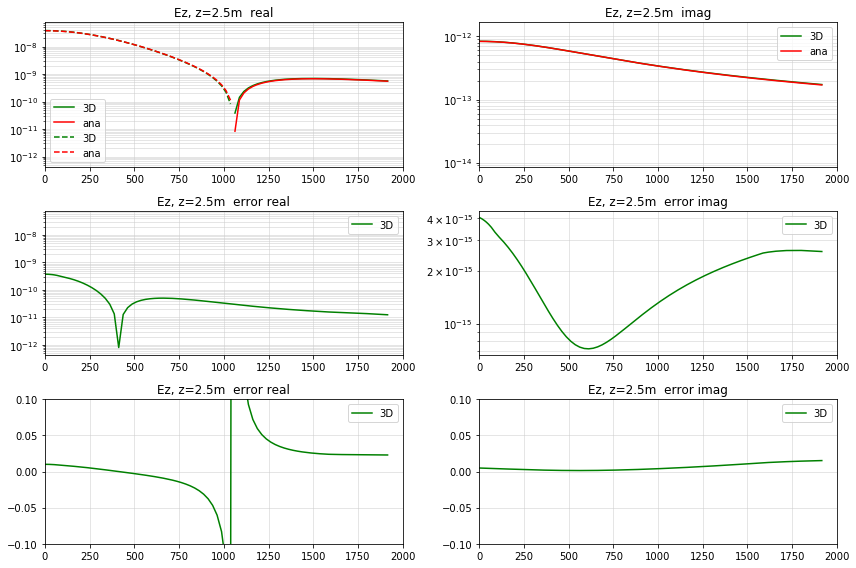

In [95]:
z_ind = mesh2D.vnC[2]/2 + 150
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(
    mesh2D.vectorCCx, e3D_z[:, z_ind], eana_z[:, z_ind], xlim=[0., 2000.], 
    name='Ez, z={}m '.format(mesh2D.vectorCCz[z_ind])
)

looking at x=137.5


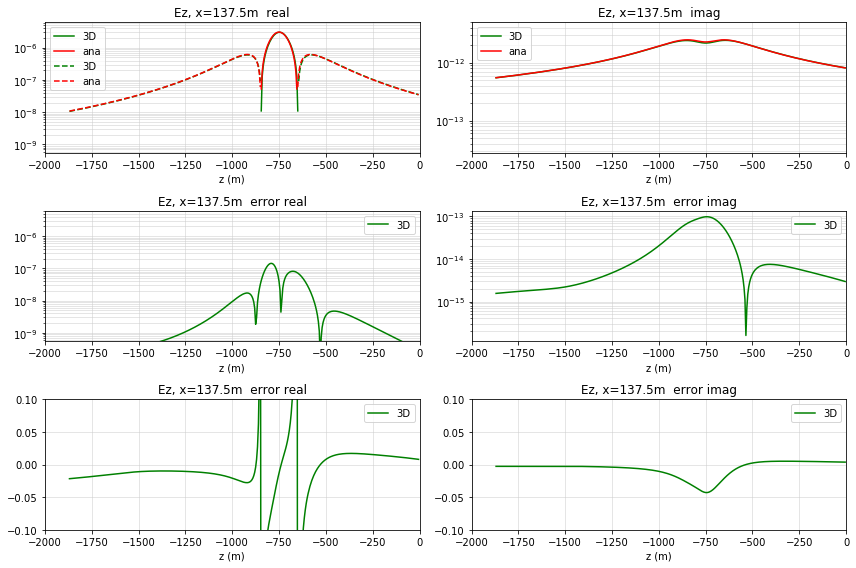

In [99]:
x_ind =  80
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(
    mesh2D.vectorNz, e3D_z[x_ind, :], eana_z[x_ind, :], xlim=[-2000., 0.], 
    name='Ez, x={}m '.format(mesh2D.vectorCCx[x_ind]), xlabel='z (m)'
)

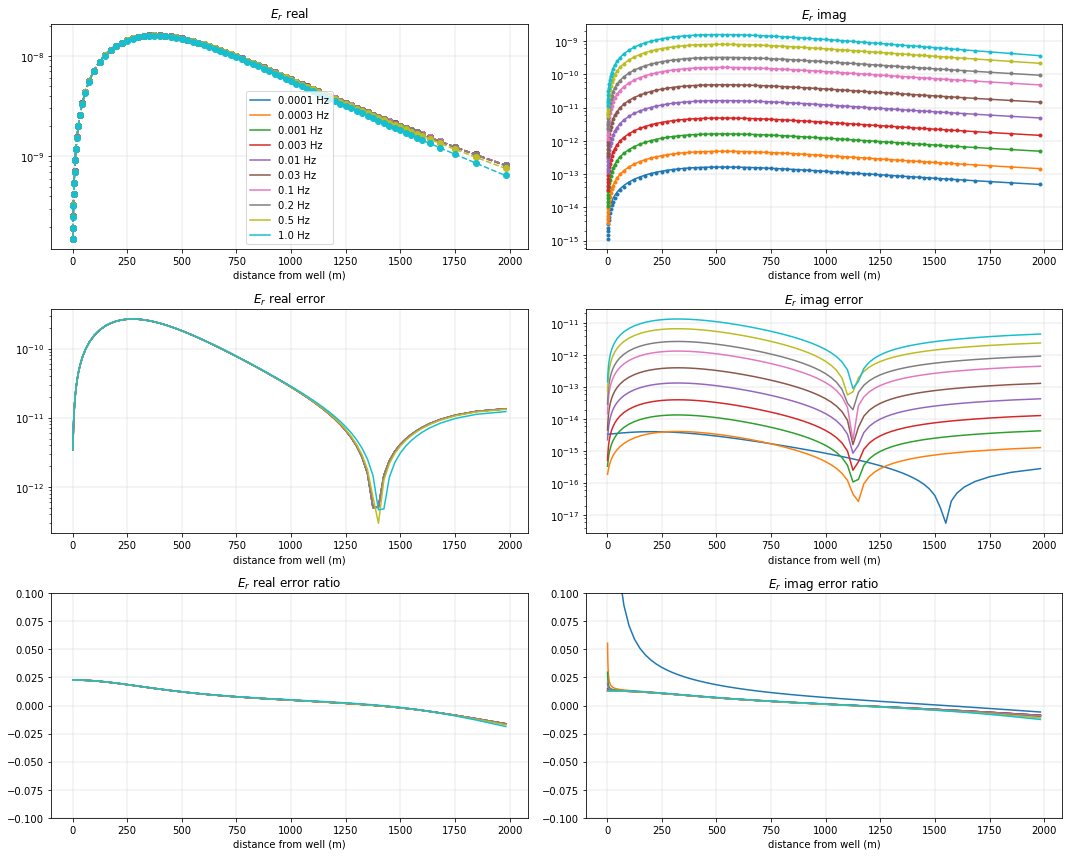

In [114]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax = utils.mkvc(ax)

for i, src in enumerate(srcList):
    ecyl = fields[src, 'e']
    eplt = casingSimulations.face3DthetaSlice(mesh, ecyl, theta_ind=theta_ind)
    
    e3D_x = utils.mkvc(eplt[:mesh2D.vnF[0]].reshape([mesh2D.vnFx[0], mesh2D.vnFx[2]], order='F'))
    

    xind = ((mesh2D.gridFx[:,0] > 2.) & (mesh2D.gridFx[:,0] < 2000.)) 
    zind = ((mesh2D.gridFx[:,2] > 0.) & (mesh2D.gridFx[:,2] < mesh2D.hz.min()))
    pltind = xind & zind
    
    eana_x, _, _ = Analytics.E_from_ElectricDipoleWholeSpace(
        mesh2D.gridFx[pltind, :], loc, sig=cp.sigma_back, f=np.r_[src.freq], current=current, 
        length=length, orientation='Z'
    )
    
    ex = e3D_x[pltind]
    x = mesh2D.gridFx[pltind, 0]
    
    label='{} Hz'.format(src.freq)
    
    ax[0].semilogy(x, -ex.real, '--', color='C{}'.format(i))
    ax[3].semilogy(x, -ex.imag, '--', color='C{}'.format(i))
    
    ax[0].semilogy(x, -eana_x.real, 'o', color='C{}'.format(i))
    ax[3].semilogy(x, -eana_x.imag, 'o', color='C{}'.format(i))
    
    ax[0].semilogy(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    ax[3].semilogy(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
    
    ax[0].semilogy(x, eana_x.real, '.', color='C{}'.format(i))
    ax[3].semilogy(x, eana_x.imag, '.', color='C{}'.format(i))
    
    ax[1].semilogy(x, np.abs(ex.real - eana_x.real), '-', color='C{}'.format(i))
    ax[4].semilogy(x, np.abs(ex.imag - eana_x.imag), '-', color='C{}'.format(i))
    
    ax[2].plot(x, (ex.real - eana_x.real)/eana_x.real, '-', color='C{}'.format(i))
    ax[5].plot(x, (ex.imag - eana_x.imag)/eana_x.imag, '-', color='C{}'.format(i))
    
#     ax[1].loglog(x, ex.real, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))
#     ax[3].loglog(x, ex.imag, '-', color='C{}'.format(i), label='{} Hz'.format(src.freq))

ax[0].legend()
ax[1].legend()

ax[0].set_title('$E_r$ real')
ax[3].set_title('$E_r$ imag')

ax[1].set_title('$E_r$ real error')
ax[4].set_title('$E_r$ imag error')

ax[2].set_title('$E_r$ real error ratio')
ax[5].set_title('$E_r$ imag error ratio')

[a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8]) for a in ax]
[a.set_xlabel('distance from well (m)') for a in ax]

[a.set_ylim(0.1*np.r_[-1., 1]) for a in [ax[2], ax[5]]]

plt.tight_layout()